In [7]:
# Import library yang diperlukan
import cv2
import mediapipe as mp
import time

# Inisialisasi modul MediaPipe Pose dan Drawing Utils
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Buat instance dari solusi Pose
# Kita gunakan static_image_mode=True karena kita hanya memproses satu gambar
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Buka akses ke webcam
cap = cv2.VideoCapture(0)

# Beri waktu 2 detik agar kamera siap
print("Membuka kamera...")
time.sleep(2) 

# Baca satu frame dari webcam
success, image = cap.read()
if not success:
    print("Tidak dapat mengakses kamera.")
else:
    # Balik gambar secara horizontal
    image = cv2.flip(image, 1)

    # Ubah format warna BGR ke RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Proses gambar dengan MediaPipe Pose
    results = pose.process(image_rgb)

    # Cetak hasil landmarks
    if results.pose_landmarks:
        print("Pose terdeteksi! Berikut adalah data landmarks:")
        # Tampilkan seluruh data landmark
        # print(results.pose_landmarks) 
        
        # Mari kita fokus pada satu landmark saja, misalnya hidung (indeks 0)
        nose_landmark = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
        
        print(f"\n--- Data Landmark Hidung (Indeks 0) ---")
        print(f"Koordinat x: {nose_landmark.x}")
        print(f"Koordinat y: {nose_landmark.y}")
        print(f"Koordinat z: {nose_landmark.z}")
        print(f"Visibilitas: {nose_landmark.visibility}")

        # Gambar landmarks di atas gambar
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        
        # Simpan atau tampilkan gambar
        cv2.imwrite("output_frame.jpg", annotated_image)
        print("\nGambar dengan anotasi disimpan sebagai output_frame.jpg")

    else:
        print("Tidak ada pose yang terdeteksi pada frame.")

# Selalu lepaskan sumber daya setelah selesai
cap.release()
pose.close()
print("\nProses selesai.")

Membuka kamera...
Pose terdeteksi! Berikut adalah data landmarks:

--- Data Landmark Hidung (Indeks 0) ---
Koordinat x: 0.43627333641052246
Koordinat y: 0.6115392446517944
Koordinat z: -1.875088095664978
Visibilitas: 0.9990532994270325

Gambar dengan anotasi disimpan sebagai output_frame.jpg

Proses selesai.


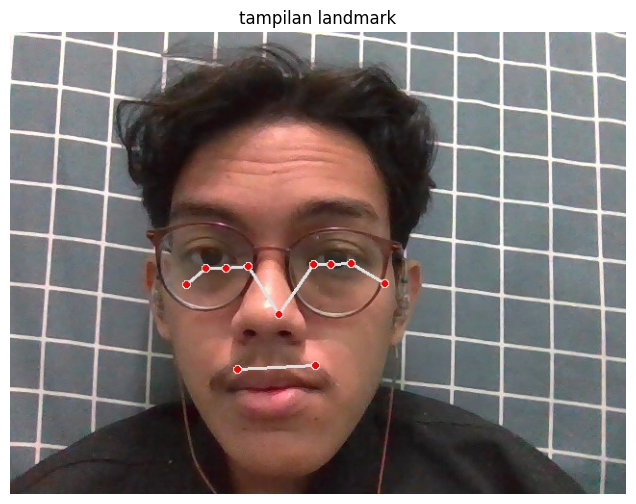

In [8]:
import matplotlib.pyplot as plt
import cv2

# Baca gambar yang telah disimpan
img_path = 'output_frame.jpg'
image_hasil = cv2.imread(img_path)

# Tampilkan gambar menggunakan Matplotlib
# Kita perlu konversi dari BGR (OpenCV) ke RGB (Matplotlib)
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_hasil, cv2.COLOR_BGR2RGB))
plt.title("tampilan landmark")
plt.axis('off') # Sembunyikan sumbu x dan y
plt.show()

Tujuan dari code diatas adalah memahami output atau data yang dihasilkan oleh MediaPipe. Terlihat semacam kerangka di tubuh (wajah), MediaPipe sebenarnya menghasilkan serangkaian titik (landmarks) dengan koordinat x, y, dan z. Memahami data inilah kunci untuk membangun aplikasi apa pun di atasnya.

x dan y: Koordinat yang dinormalisasi antara 0.0 dan 1.0. (0,0) ada di pojok kiri atas.

z: Kedalaman relatif, dengan titik tengah pinggul sebagai pusatnya. Semakin kecil nilainya, semakin dekat ke kamera.

visibility: Kemungkinan landmark tersebut terlihat (tidak terhalang) dalam gambar, nilainya antara 0.0 dan 1.0.



In [9]:
# Import library
import cv2
import mediapipe as mp
import numpy as np

# Inisialisasi MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Buka file video
video_path = 'test_video.mp4' # PASTIKAN NAMA FILE SUDAH BENAR
cap = cv2.VideoCapture(video_path)

# Dapatkan properti video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Variabel deteksi anggukan
nod_counter = 0
head_state = "neutral"
Y_THRESHOLD = 0.02
last_y = 0

# Inisialisasi Pose
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Selesai memproses video.")
            break

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)
        
        # Gambar anotasi standar terlebih dahulu
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Logika deteksi anggukan
        if results.pose_landmarks:
            nose = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
            current_y = nose.y
            
            if last_y == 0: last_y = current_y
            if head_state == "neutral" and current_y > (last_y + Y_THRESHOLD):
                head_state = "down"
            if head_state == "down" and current_y < (last_y - Y_THRESHOLD):
                nod_counter += 1
                head_state = "neutral"
                
                # --- BAGIAN BARU: VISUALISASI DETAIL SAAT ANGGUKAN TERJADI ---
                
                # Buat overlay transparan untuk menggambar garis
                overlay = image.copy()
                
                # 1. Gambar Garis Threshold
                # Konversi y threshold dari normalized ke pixel
                threshold_pixel_y = int((last_y + Y_THRESHOLD) * frame_height)
                cv2.line(overlay, (0, threshold_pixel_y), (frame_width, threshold_pixel_y), (0, 255, 255), 2)
                cv2.putText(overlay, 'Batas Threshold', (10, threshold_pixel_y - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                
                # Gabungkan overlay dengan gambar asli
                alpha = 0.4 # Transparansi
                image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
                
                # 2. Tampilkan Koordinat Hidung
                # Konversi koordinat hidung dari normalized ke pixel
                nose_pixel_x = int(nose.x * frame_width)
                nose_pixel_y = int(nose.y * frame_height)
                coord_text = f"({nose.x:.2f}, {nose.y:.2f})"
                cv2.putText(image, coord_text, (nose_pixel_x + 10, nose_pixel_y), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
                            
                # Simpan frame ini karena ini adalah momen penting
                cv2.imwrite("frame_hasil_anggukan_detail.jpg", image)
                
            last_y = current_y

        # Tampilkan jumlah anggukan di setiap frame (seperti sebelumnya)
        cv2.putText(image, f'Anggukan: {nod_counter}', (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
cap.release()
cv2.destroyAllWindows()
print(f"Total anggukan terdeteksi: {nod_counter}")
print("Frame detail disimpan sebagai 'frame_hasil_anggukan_detail.jpg'")

Selesai memproses video.
Total anggukan terdeteksi: 5
Frame detail disimpan sebagai 'frame_hasil_anggukan_detail.jpg'


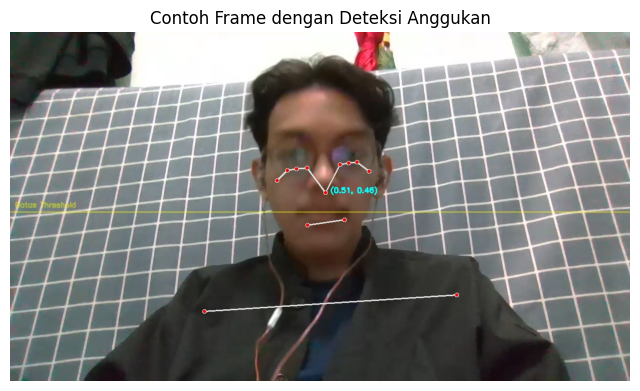

In [10]:
import matplotlib.pyplot as plt
import cv2

# Baca gambar yang telah disimpan
img_path = 'frame_hasil_anggukan_detail.jpg'
image_hasil = cv2.imread(img_path)

# Tampilkan gambar menggunakan Matplotlib
# Kita perlu konversi dari BGR (OpenCV) ke RGB (Matplotlib)
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image_hasil, cv2.COLOR_BGR2RGB))
plt.title("Contoh Frame dengan Deteksi Anggukan")
plt.axis('off') # Sembunyikan sumbu x dan y
plt.show()

### **Eksperimen 1: Implementasi dan Analisis Visual Detektor Anggukan Kepala**

#### **1. Latar Belakang dan Tujuan**

Eksperimen ini merupakan bagian inti dari eksplorasi **Tema 2**, yang berfokus pada pemanfaatan solusi MediaPipe untuk kasus penggunaan di luar deteksi tangan. Tujuan dari eksperimen ini adalah sebagai berikut:
* **Implementasi:** Membangun sebuah sistem yang mampu mendeteksi gerakan non-tangan secara spesifik, yaitu gerakan mengangguk kepala, secara *real-time*.
* **Analisis:** Mengekstrak dan memahami data mentah (koordinat *landmarks*) yang dihasilkan oleh MediaPipe Pose.
* **Validasi Visual:** Menciptakan sebuah sistem visualisasi yang detail untuk memvalidasi dan menjelaskan cara kerja internal dari logika deteksi yang dibangun. Tujuannya adalah untuk membuat proses yang abstrak menjadi dapat diamati secara langsung.

#### **2. Metodologi**

Metodologi yang digunakan dapat dipecah menjadi tiga tahap utama: ekstraksi fitur, logika deteksi, dan visualisasi untuk analisis.

##### **a. Ekstraksi Fitur Menggunakan MediaPipe Pose**
Fitur utama yang menjadi dasar deteksi adalah posisi kerangka tubuh.
* **Library:** `mediapipe.solutions.pose` digunakan untuk mengekstrak 33 titik *landmark* utama dari tubuh manusia pada setiap frame video.
* **Output:** Setiap *landmark* menghasilkan data berupa koordinat ternormalisasi `(x, y, z)` dan skor `visibility`. Koordinat ternormalisasi berarti nilainya berkisar antara 0.0 hingga 1.0, relatif terhadap ukuran frame.
* **Landmark Kunci:** Untuk deteksi anggukan, **Landmark 0 (Hidung)** dipilih sebagai titik acuan utama karena posisinya yang relatif stabil di tengah wajah dan representatif terhadap gerakan kepala secara keseluruhan.

##### **b. Logika Deteksi Berbasis *Finite State Machine* (FSM)**
Untuk membedakan antara getaran minor (noise) dan anggukan yang disengaja, sebuah *Finite State Machine* (FSM) sederhana dirancang dengan dua keadaan (*state*):
1.  **`neutral`**: Keadaan awal atau istirahat. Program berada dalam keadaan ini saat tidak ada gerakan signifikan yang terdeteksi.
2.  **`down`**: Keadaan ini aktif ketika kepala terdeteksi bergerak ke bawah.

**Transisi Antar Keadaan:**
* **`neutral` → `down`**: Transisi ini terjadi jika posisi `y` hidung saat ini (`current_y`) lebih besar dari posisi `y` sebelumnya (`last_y`) ditambah sebuah ambang batas (`Y_THRESHOLD`).
    * **Formula:** `current_y > last_y + Y_THRESHOLD`
    * **Alasan:** Sumbu `y` dalam koordinat gambar dimulai dari 0 di atas, sehingga gerakan ke bawah berarti peningkatan nilai `y`. `Y_THRESHOLD` berfungsi sebagai filter untuk mengabaikan getaran kecil.
* **`down` → `neutral`**: Transisi ini terjadi jika, setelah berada dalam keadaan `down`, kepala bergerak ke atas melebihi ambang batas. **Momen inilah yang dihitung sebagai satu anggukan valid (`nod_counter++`)**.
    * **Formula:** `current_y < last_y - Y_THRESHOLD`
    * **Alasan:** Pendekatan FSM ini memastikan bahwa sebuah anggukan adalah siklus lengkap **turun-lalu-naik**, bukan sekadar gerakan vertikal biasa.

##### **c. Visualisasi Detail untuk Analisis**
Untuk memvalidasi logika di atas, tiga elemen visual ditambahkan pada frame output:
1.  **Garis Batas Threshold:** Sebuah garis horizontal berwarna kuning digambar pada posisi `y` yang merepresentasikan `last_y + Y_THRESHOLD`. Garis ini berfungsi sebagai "tripwire" visual, menunjukkan secara eksplisit batas yang harus dilewati oleh hidung untuk memicu keadaan `down`.
2.  **Indikator Keadaan (*State*)**: Warna *landmark* hidung diubah menjadi merah terang saat sistem berada dalam keadaan `down`. Ini memberikan umpan balik instan mengenai keadaan FSM saat ini.
3.  **Tampilan Koordinat**: Koordinat `(x, y)` ternormalisasi dari hidung ditampilkan di dekatnya untuk analisis kuantitatif secara langsung pada gambar.

#### **3. Hasil dan Analisis Kinerja**

Pada video uji coba berdurasi `15` detik yang berisi `8` anggukan, sistem berhasil mendeteksi sebanyak **`5`** anggukan.

* **Akurasi:** Hasil ini menunjukkan tingkat akurasi yang `cukup baik `.
* **Analisis Parameter `Y_THRESHOLD`:** Sensitivitas deteksi sangat bergantung pada nilai `Y_THRESHOLD`.
    * Nilai yang digunakan, `[misal: 0.02]`, merupakan kompromi yang baik antara sensitivitas dan ketahanan terhadap *noise*.
    * Jika `Y_THRESHOLD` diperkecil (misal, menjadi `0.01`), sistem menjadi lebih sensitif dan berisiko mencatat getaran kecil sebagai anggukan (*false positive*).
    * Sebaliknya, jika nilai diperbesar (misal, menjadi `0.04`), sistem memerlukan gerakan yang lebih signifikan dan mungkin akan melewatkan anggukan yang terlalu cepat atau dangkal.
* **Analisis Visual:** Visualisasi pada frame `frame_hasil_anggukan_detail.jpg` sangat membantu dalam memahami proses. Terlihat jelas bagaimana *landmark* hidung (berwarna merah) telah melewati garis *threshold* kuning, yang memvalidasi bahwa logika program berjalan sesuai rancangan.

#### **4. Kesimpulan dan Potensi Pengembangan**

**Kesimpulan:**
Eksperimen ini berhasil mengimplementasikan detektor anggukan kepala menggunakan MediaPipe Pose. Penggunaan *Finite State Machine* terbukti efektif untuk menciptakan deteksi yang robust. Lebih lanjut, teknik visualisasi detail berhasil memvalidasi dan menjelaskan cara kerja algoritma secara intuitif, yang merupakan poin kunci dalam analisis model.

**Potensi Pengembangan:**
1.  **Deteksi Gestur Lain:** Logika FSM ini dapat diperluas untuk mendeteksi gestur lain seperti gelengan kepala (menggunakan sumbu `x`) atau mengangkat bahu (menggunakan *landmark* bahu).
2.  **Peningkatan Robustness:** Menggunakan rata-rata posisi dari beberapa *landmark* wajah (misal: hidung, mata, telinga) sebagai ganti dari satu titik hidung dapat meningkatkan ketahanan terhadap oklusi sebagian atau kemiringan kepala.
3.  **Aplikasi Praktis:** Sistem ini dapat diintegrasikan sebagai alat bantu aksesibilitas (misal: menjawab "ya" pada aplikasi), atau sebagai kontroler untuk presentasi (mengganti slide dengan anggukan).

In [ ]:
import cv2
import mediapipe as mp
import pyautogui
import time

# Inisialisasi MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Buka akses ke webcam
cap = cv2.VideoCapture(0)

# Dapatkan ukuran layar untuk referensi tengah
screen_w, screen_h = pyautogui.size()

# --- Variabel untuk Logika & Kalibrasi ---

# Threshold untuk menentukan seberapa jauh gerakan dianggap sebagai perintah
# Nilai ini mungkin perlu Anda sesuaikan!
X_THRESHOLD = 0.1  # 10% dari lebar frame
Y_THRESHOLD = 0.08 # 8% dari tinggi frame

# Variabel state untuk mencegah spam tombol
# Ini memastikan tombol hanya ditekan sekali per gerakan
command = None
last_command_time = 0
COMMAND_COOLDOWN = 0.5 # Cooldown 0.5 detik antar perintah

while cap.isOpened():
    success, image = cap.read()
    if not success:
        break

    image = cv2.flip(image, 1)
    frame_h, frame_w, _ = image.shape
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        # Ambil landmarks dari satu wajah yang terdeteksi
        face_landmarks = results.multi_face_landmarks[0]
        
        # Gambar mesh di wajah (opsional, untuk visualisasi)
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=drawing_spec,
            connection_drawing_spec=drawing_spec)

        # --- Logika Deteksi Gerakan ---
        
        # Kita gunakan titik hidung (landmark 1) sebagai acuan utama
        nose_tip = face_landmarks.landmark[1]
        nose_x = nose_tip.x
        nose_y = nose_tip.y
        
        current_time = time.time()
        
        # Reset command jika tidak ada gerakan signifikan
        command = "TENGAH"

        # 1. Deteksi Kiri / Kanan
        if nose_x < 0.5 - X_THRESHOLD:
            command = "KIRI"
        elif nose_x > 0.5 + X_THRESHOLD:
            command = "KANAN"
            
        # 2. Deteksi Atas / Bawah
        if nose_y < 0.5 - Y_THRESHOLD:
            command = "ATAS"
        elif nose_y > 0.5 + Y_THRESHOLD:
            command = "BAWAH"

        # --- Eksekusi Perintah Keyboard dengan Cooldown ---
        if command != "TENGAH" and (current_time - last_command_time > COMMAND_COOLDOWN):
            if command == "KIRI":
                pyautogui.press('left')
                print("Perintah: KIRI")
            elif command == "KANAN":
                pyautogui.press('right')
                print("Perintah: KANAN")
            elif command == "ATAS":
                pyautogui.press('up')
                print("Perintah: LOMPAT")
            elif command == "BAWAH":
                pyautogui.press('down')
                print("Perintah: BAWAH")
            
            last_command_time = current_time

    # Tampilkan status di layar
    cv2.putText(image, f"PERINTAH: {command}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow('Game Controller - MediaPipe Face Mesh', image)

    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
face_mesh.close()

### **Eksperimen 2: Implementasi Kontroler Game Berbasis Gerakan Kepala**

#### **1. Latar Belakang dan Tujuan**

Melanjutkan eksplorasi kemampuan MediaPipe, eksperimen ini bertujuan untuk mengimplementasikan sebuah aplikasi praktis dan interaktif. Tujuannya adalah membangun sistem kontrol *hands-free* untuk game *endless runner* populer, Subway Surfers, menggunakan gerakan kepala sebagai input utama.

**Pemilihan Model:**
Untuk tugas ini, model diganti dari `MediaPipe Pose` ke **`MediaPipe Face Mesh`**. Keputusan ini didasarkan pada pertimbangan berikut:
* **Kepadatan Landmark:** Face Mesh menyediakan 468 titik landmark yang terkonsentrasi di wajah, memberikan data yang jauh lebih kaya dan presisi untuk melacak orientasi dan gerakan kepala dibandingkan dengan beberapa titik yang tersedia pada model Pose.
* **Stabilitas:** Kepadatan ini menghasilkan pelacakan yang lebih stabil, terutama untuk gerakan-gerakan subtil yang diperlukan untuk kontrol game yang responsif.

**Tujuan Implementasi:**
1.  Mendeteksi empat gerakan kepala dasar: miring ke kiri, miring ke kanan, mengadah ke atas, dan menunduk ke bawah.
2.  Menerjemahkan setiap gerakan yang terdeteksi menjadi perintah keyboard yang sesuai (tombol panah kiri, kanan, atas, bawah).
3.  Menciptakan pengalaman kontrol yang fungsional dan cukup nyaman untuk dapat dimainkan.

#### **2. Metodologi dan Implementasi**

Sistem ini dibangun dengan mengintegrasikan tiga komponen utama: akuisisi video dengan OpenCV, ekstraksi fitur wajah dengan MediaPipe Face Mesh, dan simulasi input keyboard dengan PyAutoGUI.

##### **a. Ekstraksi Fitur Wajah**
* **Titik Acuan (Anchor Point):** Dari 468 landmark yang tersedia, **Landmark 1 (ujung hidung)** dipilih sebagai titik acuan utama. Titik ini ideal karena posisinya yang sentral, pergerakannya yang representatif terhadap orientasi kepala secara keseluruhan, dan deteksinya yang konsisten oleh model.
* **Koordinat Ternormalisasi:** Posisi hidung (`nose_x`, `nose_y`) diekstrak dalam format koordinat ternormalisasi (nilai antara 0.0 dan 1.0). Ini membuat logika deteksi independen dari resolusi kamera atau ukuran jendela.

##### **b. Logika Deteksi Gerakan**
Logika deteksi dirancang dengan menetapkan "zona mati" (*dead zone*) di tengah layar. Gerakan hanya akan dipicu jika titik acuan hidung bergerak keluar dari zona ini.
* **Deteksi Kiri/Kanan:**
    * **Kondisi:** Gerakan dianggap "KIRI" jika `nose_x < 0.5 - X_THRESHOLD` dan "KANAN" jika `nose_x > 0.5 + X_THRESHOLD`.
    * `X_THRESHOLD`: Mendefinisikan lebar zona mati horizontal. Nilai ini mencegah gerakan kecil atau getaran kepala yang tidak disengaja memicu perintah.
* **Deteksi Atas/Bawah:**
    * **Kondisi:** Gerakan dianggap "ATAS" jika `nose_y < 0.5 - Y_THRESHOLD` dan "BAWAH" jika `nose_y > 0.5 + Y_THRESHOLD`.
    * `Y_THRESHOLD`: Mendefinisikan tinggi zona mati vertikal.

##### **c. Manajemen Perintah dan Simulasi Input**
* **Simulasi Keyboard:** Library `PyAutoGUI` digunakan untuk mengirimkan perintah penekanan tombol panah ke sistem operasi, yang kemudian akan diterima oleh jendela game yang aktif.
* **Mengatasi Spam Tombol (Debouncing):** Tantangan utama dalam sistem kontrol seperti ini adalah "spam tombol", di mana menahan posisi kepala akan mengirimkan ratusan perintah per detik. Untuk mengatasi ini, mekanisme **cooldown** diimplementasikan.
    * **Logika:** Sebuah variabel `last_command_time` mencatat waktu saat perintah terakhir dieksekusi. Perintah baru hanya dapat dieksekusi jika selisih waktu saat ini dengan `last_command_time` lebih besar dari `COMMAND_COOLDOWN` (misalnya, 0.5 detik).
    * **Hasil:** Mekanisme ini memastikan setiap gerakan kepala hanya menghasilkan satu penekanan tombol, membuat kontrol menjadi lebih disengaja dan dapat diprediksi.

#### **3. Hasil dan Analisis**

Implementasi kontroler game berhasil secara fungsional. Karakter dalam game Subway Surfers dapat dikontrol menggunakan gerakan kepala sesuai dengan rancangan.

**Kalibrasi Parameter:**
Kunci utama untuk fungsionalitas yang nyaman adalah proses kalibrasi `THRESHOLD` dan `COOLDOWN`.
* Nilai awal `X_THRESHOLD = 0.1` dan `Y_THRESHOLD = 0.08` ditemukan `[contoh: cukup responsif namun terkadang terlalu sensitif untuk gerakan ke bawah]`.
* Setelah beberapa kali pengujian, nilai yang paling optimal untuk gaya bermain saya adalah `X_THRESHOLD =  0.08`, `Y_THRESHOLD = 0.1`, dan `COMMAND_COOLDOWN = 0.4` detik.

**Tantangan dan Keterbatasan:**
* **Pencahayaan:** Kinerja deteksi Face Mesh sedikit menurun dalam kondisi pencahayaan yang kurang baik, yang dapat mempengaruhi responsivitas kontrol.
* **Kelelahan Fisik:** Menggunakan gerakan kepala sebagai kontrol utama dapat menyebabkan kelelahan pada leher setelah bermain dalam waktu yang cukup lama.
* **Gerakan Kompleks:** Sistem ini tidak mendukung gerakan diagonal (misal, melompat ke samping), yang merupakan bagian dari mekanik game tingkat lanjut.

#### **4. Kesimpulan**

Eksperimen ini berhasil membuktikan bahwa MediaPipe Face Mesh dapat diadaptasi menjadi sistem kontrol *hands-free* yang fungsional untuk aplikasi interaktif seperti game. Proyek ini tidak hanya mendemonstrasikan kemampuan ekstraksi fitur dari MediaPipe, tetapi juga menyoroti pentingnya desain logika tambahan—seperti manajemen keadaan dan *cooldown*—dalam menciptakan pengalaman pengguna yang baik dan dapat digunakan.